# Segmentación con K-Means y aplicación de PCA

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ymeza@ubiobio.cl

**Fecha de Creación:** Junio 2025

**Versión:** 1.0  



---

## Descripción


Este notebook implementa un modelo de segmentación usando primero una selección arbitraria de características y luego considerando todas las características disponibles para poder aplicar PCA.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:


- numpy (2.2.2)
- pandas (2.0.2)
- matplotlib (3.10.0)
- seaborn (0.13.2)
- sklearn (1.6.1)
- kneed (0.8.5)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

In [ ]:
!pip install kneed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from kneed import KneeLocator

In [ ]:
# Para reproducibilidad dado que se van a generar datos sintéticos
np.random.seed(29)

# Simulación de datos: 200 usuarios con 4 características
data = {
    'edad': np.random.randint(18, 60, 200),
    'ingresos_mensuales': np.random.randint(300, 2500, 200),
    'horas_ejercicio': np.random.randint(0, 15, 200),
    'frecuencia_semanal': np.random.randint(0, 7, 200)
}

data_frame_inicial = pd.DataFrame(data)
data_frame_inicial.head()

,edad,ingresos_mensuales,horas_ejercicio,frecuencia_semanal
0,39,2197,11,3
1,52,591,7,3
2,58,303,6,0
3,50,1767,7,5
4,59,1524,11,6


# Modelo usando sólo dos características

En esta sección se seleccionan de forma arbitraria dos de las cuatro características disponobles. Esta selección se hace en función del sentido que se quiere dar al modelo de segmentación, en este caso, se trata de agrupar a las personas en función de su `edad` y su nivel de `ingresos mensuales`.

## Selección y escalado de las 2 características

In [ ]:
features = ['edad', 'ingresos_mensuales']
data_frame_simple = data_frame_inicial[features].copy()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_frame_simple)

## Obtención de la cantidad óptima de clusters

In [ ]:
sse = []
for k in range(2, 21):
  kkmeans = KMeans(n_clusters=k, n_init="auto", random_state = 29).fit(X_scaled)
  sse.append(kkmeans.inertia_)
kl = KneeLocator(range(2, 21), sse, curve="convex", direction="decreasing")

print("El codo está en k =", kl.elbow)
print("El SSE =", np.round(kl.all_elbows_y, 2))

El codo está en k = 5
El SSE = [79.27]


## Visualiza la cantidad de clusters óptimo

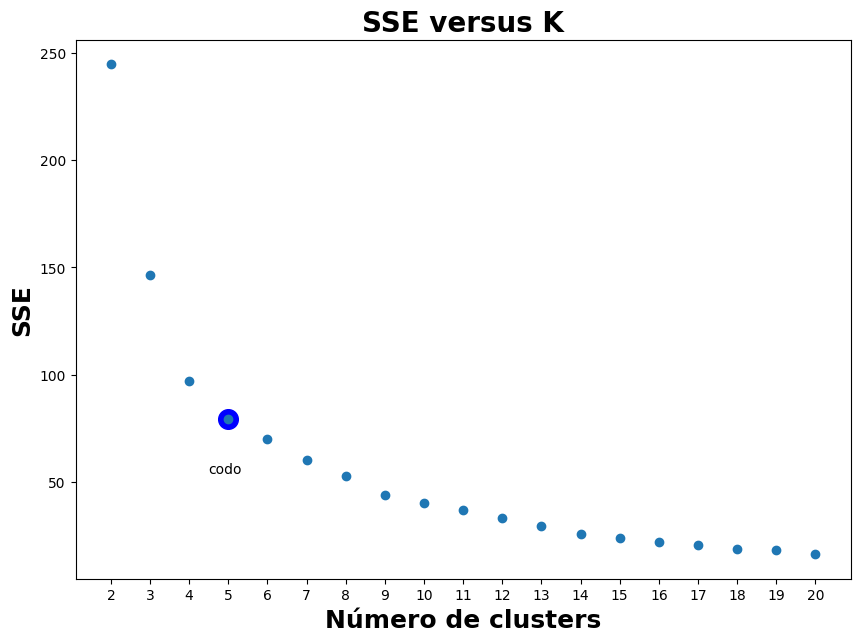

In [ ]:
fig, ax = plt.subplots(figsize = (10, 7))

# estas dos lineas se agregan para que se vea la elección de KneeLocator para el codo en este gráfico
ax.scatter(kl.elbow, sse[kl.elbow-2], color='blue', s=200) # agrega un punto rojo al plot de tamaño s=200 en el lugar donde se encuentra el codo
ax.text(kl.elbow-.5, sse[kl.elbow-2]-25, s="codo")       # agrega un texto abajo para indicar qué representa el punto

# estas lineas son el grafico de SS vs K
ax.scatter(range(2, 21), sse)
ax.set_xticks(range(2, 21))
ax.set_xlabel("Número de clusters", fontsize=18, fontweight="bold")
ax.set_ylabel("SSE", fontsize=18, fontweight="bold")
plt.title("SSE versus K", fontsize=20, fontweight="bold")
plt.show()

## Construcción del modelo

In [ ]:
# Primera aplicación de KMeans con las características seleccionadas
kmeans_x= KMeans(n_clusters=kl.elbow, n_init=10, random_state = 29)
grupos = kmeans_x.fit_predict(X_scaled)
data_frame_simple['grupo'] = grupos

In [ ]:
# Silhouette Score en espacio seleccionado
silhouette_simple= silhouette_score(X_scaled, grupos)
print(f"Silhouette Score (espacio seleccionado): {silhouette_simple:.4f}")

Silhouette Score (espacio seleccionado): 0.3970


## Visualización de grupos

In [ ]:
# Obtiene los centroides en escala original
centroides_escalados = kmeans_x.cluster_centers_
centroides_originales = scaler.inverse_transform(centroides_escalados)

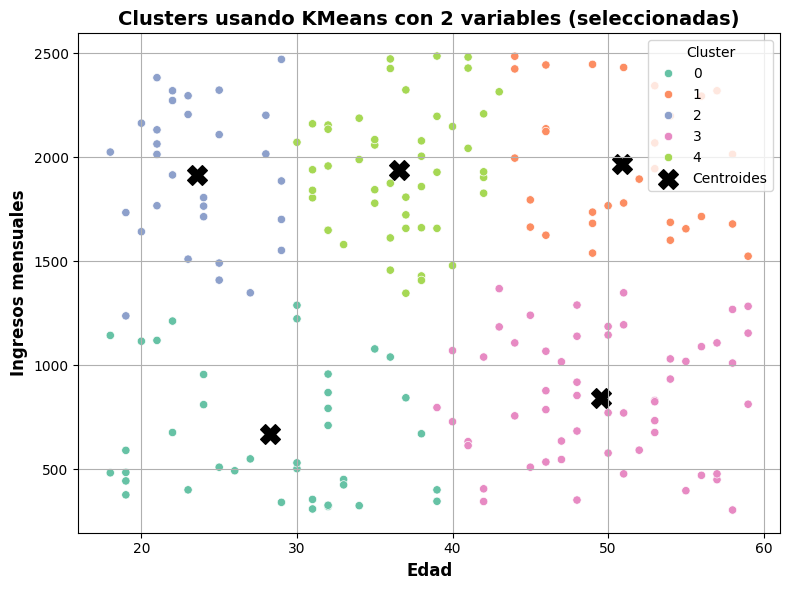

In [ ]:
# Gráfica de los grupos
plt.figure(figsize=(8,6))
sns.scatterplot(data=data_frame_simple, x='edad', y='ingresos_mensuales', hue='grupo', palette='Set2')
plt.scatter(centroides_originales[:, 0], centroides_originales[:, 1],
            s=200, c='black', marker='X', label='Centroides')
plt.title("Clusters usando KMeans con 2 variables (seleccionadas)", fontsize=14, fontweight="bold")
plt.xlabel("Edad", fontsize=12, fontweight="bold")
plt.ylabel("Ingresos mensuales", fontsize=12, fontweight="bold")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

## Análisis de grupos

Acá se analizan los centroides, primero en su versión escalada y, dado que ahí no hay interpretabilidad, entonces se analizan con sus centroides en la escala original.

In [ ]:
centroides = kmeans_x.cluster_centers_
print(centroides)

[[-0.90416081 -1.10100041]
 [ 1.04392002  0.86312103]
 [-1.30619129  0.78512536]
 [ 0.92861874 -0.83745162]
 [-0.18825067  0.81809496]]


In [ ]:
df_centroides = pd.DataFrame(centroides_originales, columns=['edad', 'ingresos_mensuales']).round(2)
df_centroides['cluster'] = range(kl.elbow)
df_centroides

,edad,ingresos_mensuales,cluster
0,28.24,669.63,0
1,50.87,1967.37,1
2,23.57,1915.83,2
3,49.53,843.76,3
4,36.55,1937.62,4


✅ **Análisis**

Cluster 1

+ Las personas de este grupo presentan una edad promedio de 51 años y un ingreso mensual equivalente a 1967,37 unidades monetarias mensuales

# Modelo usando todas las características

En esta sección se seleccionan más de dos características con el objetivo de mostrar el uso de PCA como técnica de reducción de la dimensionalidad.

En este caso, dado que justo son cuatro caracterñisticas, entonces se seleccionan todas.

## Escalado de datos

In [ ]:
data_frame_all = data_frame_inicial.copy()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_frame_all)

## Obtención de número de cluster óptimo

In [ ]:
sse = []
for k in range(2, 21):
  kkmeans = KMeans(n_clusters=k, n_init="auto", random_state = 29).fit(X_scaled)
  sse.append(kkmeans.inertia_)

kl = KneeLocator(range(2, 21), sse, curve="convex", direction="decreasing")

print("El codo está en k =", kl.elbow)
print(f"El SSE = {np.round(kl.all_elbows_y, 2)}")

El codo está en k = 9
El SSE = [245.88]


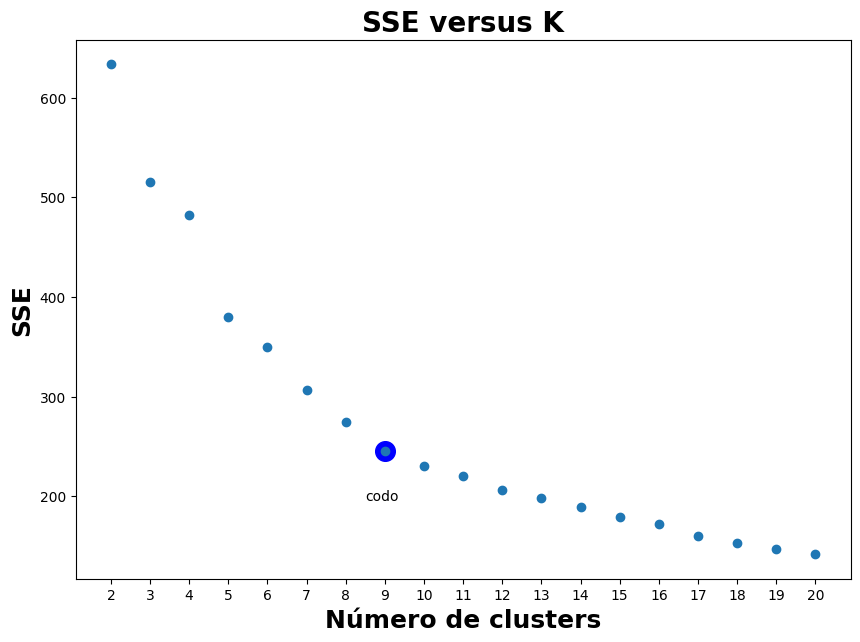

In [ ]:
fig, ax = plt.subplots(figsize = (10, 7))

# estas dos lineas se agregan para que se vea la elección de KneeLocator para el codo en este gráfico
ax.scatter(kl.elbow, sse[kl.elbow-2], color='blue', s=200) # agrega un punto rojo al plot de tamaño s=200 en el lugar donde se encuentra el codo
ax.text(kl.elbow-.5, sse[kl.elbow-2]-50, s="codo")       # agrega un texto abajo para indicar qué representa el punto

# estas lineas son el grafico de SS vs K
ax.scatter(range(2, 21), sse)
ax.set_xticks(range(2, 21))
ax.set_xlabel("Número de clusters", fontsize=18, fontweight="bold")
ax.set_ylabel("SSE", fontsize=18, fontweight="bold")
plt.title("SSE versus K", fontsize=20, fontweight="bold")
plt.show()

## Construcción del modelo

In [ ]:
# Primera aplicación de KMeans con los datos originales
kmeans_inicial = KMeans(n_clusters=kl.elbow, n_init=10, random_state = 29)
grupos = kmeans_inicial.fit_predict(X_scaled)
data_frame_all['grupo'] = grupos

In [ ]:
# Silhouette Score en espacio original
silhouette_orig = silhouette_score(X_scaled, grupos)
print(f"Silhouette Score (espacio original): {silhouette_orig:.4f}")

Silhouette Score (espacio original): 0.2699


## Análisis de grupos

In [ ]:
centroides_all = kmeans_inicial.cluster_centers_
print(centroides_all)

[[ 0.73155567 -0.13237968 -1.12968313 -0.79338572]
 [ 0.55213379 -0.91888107 -0.11601108  1.05572884]
 [-1.02498139  0.35592212  0.64435256  0.87370663]
 [-1.00030379 -1.20009161 -0.5601678  -0.69168442]
 [ 1.19408993  0.59879675  0.96021166  0.67820129]
 [-0.26898146  0.86931862  1.01647806 -0.71782094]
 [ 0.20361288  1.18780916 -0.67910581  1.00463489]
 [-1.18786708  0.86034035 -1.34761334 -0.51465889]
 [ 0.90474981 -0.93515604  0.72414855 -0.7644933 ]]


In [ ]:
# Obtiene los centroides en escala original
centroides_all_originales = scaler.inverse_transform(centroides_all)

In [ ]:
df_all_centroides = pd.DataFrame(centroides_all_originales, columns=data_frame_inicial.columns).round(2)
df_all_centroides['cluster'] = range(kl.elbow)
df_all_centroides

,edad,ingresos_mensuales,horas_ejercicio,frecuencia_semanal,cluster
0,47.24,1309.62,2.38,1.19,0
1,45.15,789.96,6.62,5.00,1
2,26.83,1632.25,9.79,4.62,2
3,27.12,604.16,4.76,1.40,3
4,52.61,1792.72,11.11,4.22,4
5,35.62,1971.46,11.35,1.35,5
6,41.11,2181.89,4.26,4.89,6
7,24.94,1965.53,1.47,1.76,7
8,49.25,779.21,10.12,1.25,8


## Visualización de los grupos

Acá sólo se aplica PCA para efectos de visualización

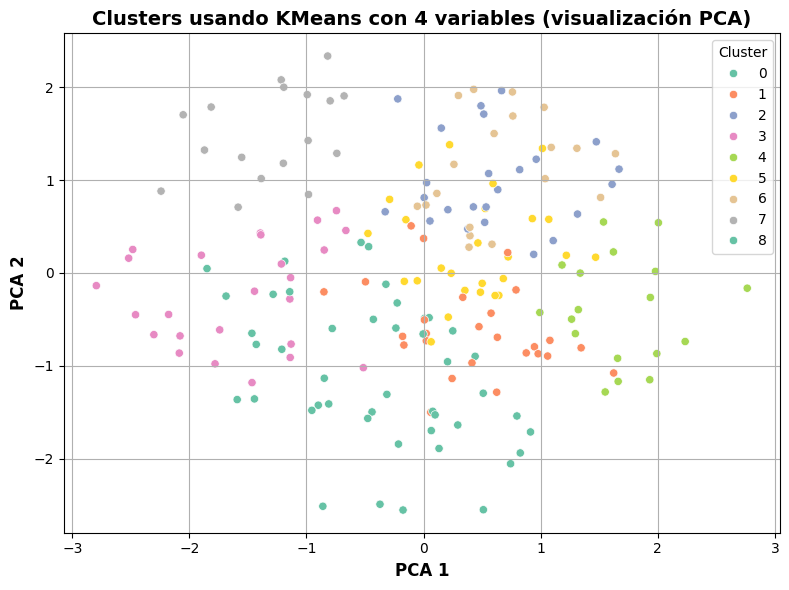

In [ ]:
# Visualización usando PCA
# (sólo para graficar clusters originales, por esa razón el número de componentes es 2
pca_visual = PCA(n_components=2)
X_visual = pca_visual.fit_transform(X_scaled)
data_frame_all['pca1'] = X_visual[:, 0]
data_frame_all['pca2'] = X_visual[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=data_frame_all, x='pca1', y='pca2', hue='grupo', palette='Set2')

plt.title("Clusters usando KMeans con 4 variables (visualización PCA)", fontsize=14, fontweight="bold")
plt.xlabel("PCA 1", fontsize=12, fontweight="bold")
plt.ylabel("PCA 2", fontsize=12, fontweight="bold")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

## Aplicación de PCA

### Selección de la cantidad de componentes


Varianza explicada por cada componente:
Componente 1: 0.3021  |  Acumulada: 0.3021
Componente 2: 0.2813  |  Acumulada: 0.5834
Componente 3: 0.2190  |  Acumulada: 0.8024
Componente 4: 0.1976  |  Acumulada: 1.0000


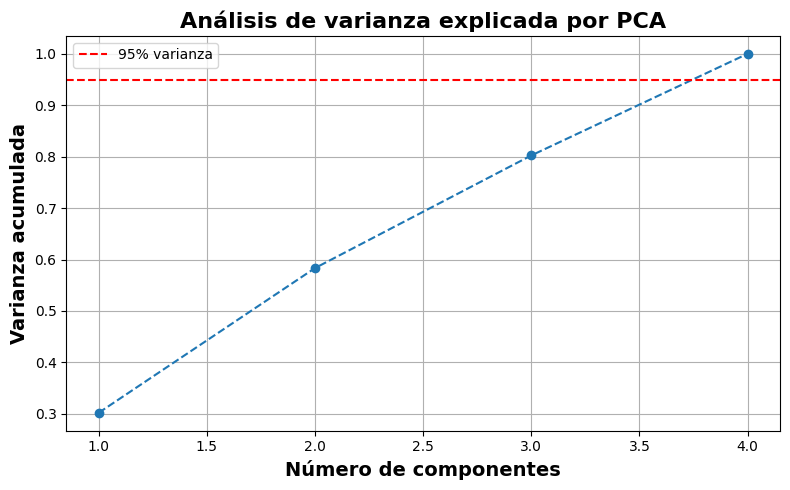


Número de componentes que explican >=95.0% de la varianza: 4


In [ ]:
# Análisis de varianza explicada por PCA
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Varianza explicada por cada componente
varianza_explicada = pca_full.explained_variance_ratio_
varianza_explicada_acumulada = np.cumsum(varianza_explicada)

# Mostrar tabla con varianza explicada
print("\nVarianza explicada por cada componente:")
for i, (v_ind, v_acum) in enumerate(zip(varianza_explicada, varianza_explicada_acumulada), 1):
    print(f"Componente {i}: {v_ind:.4f}  |  Acumulada: {v_acum:.4f}")

# Visualizar varianza acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(varianza_explicada) + 1), varianza_explicada_acumulada, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
plt.xlabel('Número de componentes', fontsize=14, fontweight="bold")
plt.ylabel('Varianza acumulada', fontsize=14, fontweight="bold")
plt.title('Análisis de varianza explicada por PCA', fontsize=16, fontweight="bold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Elegir número óptimo de componentes (>= 95% varianza)
umbral = 0.95
n_componentes_optimos = np.argmax(varianza_explicada_acumulada >= umbral) + 1
print(f"\nNúmero de componentes que explican >={umbral*100}% de la varianza: {n_componentes_optimos}")

-------------------------------------------------------
Porcentaje de varianza explicada por cada componente
-------------------------------------------------------
[0.30209563 0.28129156 0.21897643 0.19763639]


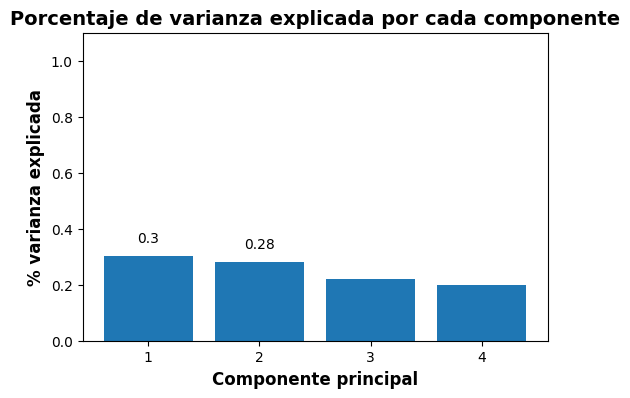

In [ ]:
print('-'*55)
print('Porcentaje de varianza explicada por cada componente')
print('-'*55)
print(pca_full.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca_full.n_components_) + 1,
    height = pca_full.explained_variance_ratio_
)

for x, y in zip(np.arange(len(features)) + 1, pca_full.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca_full.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente', fontsize=14, fontweight="bold")
ax.set_xlabel('Componente principal', fontsize=12, fontweight="bold")
ax.set_ylabel('% varianza explicada', fontsize=12, fontweight="bold");

### Aplicación de PCA con óptimo de componentes

In [ ]:
# Aplicar PCA con número óptimo de componentes obtenido en el punto anterior
pca = PCA(n_components=n_componentes_optimos)
X_pca = pca.fit_transform(X_scaled)

## Construcción de modelo sobre las componentes principales

Silhouette Score (espacio PCA): 0.2699


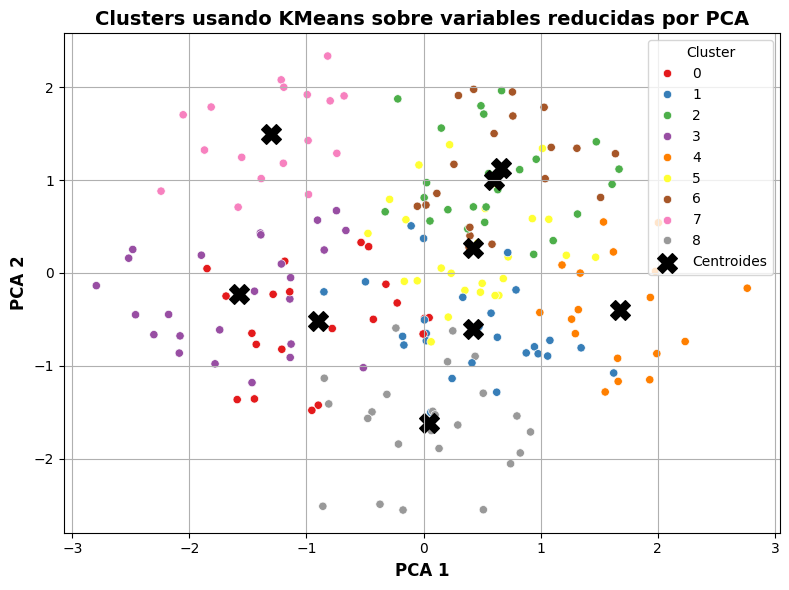

In [ ]:
# KMeans sobre las componentes principales
kmeans_pca = KMeans(n_clusters=kl.elbow, n_init=10, random_state=29)
clusters_pca = kmeans_pca.fit_predict(X_pca)

# Visualización del resultado de aplicar KMeans sobre PCA
data_frame_all['cluster_pca'] = clusters_pca

silhouette_pca = silhouette_score(X_pca, clusters_pca)
print(f"Silhouette Score (espacio PCA): {silhouette_pca:.4f}")

# Obtener los centroides en el espacio PCA
centroides_pca = kmeans_pca.cluster_centers_

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_pca, palette='Set1')
plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1],
            s=200, c='black', marker='X', label='Centroides')
plt.title("Clusters usando KMeans sobre variables reducidas por PCA", fontsize=14, fontweight="bold")
plt.xlabel("PCA 1", fontsize=12, fontweight="bold")
plt.ylabel("PCA 2", fontsize=12, fontweight="bold")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Comparación ---
print("Porcentaje de varianza explicada por PCA:\n", pca.explained_variance_ratio_)
print("-"*75)
print("Centroides en espacio original:\n", kmeans_inicial.cluster_centers_)
print("-"*75)
print("Centroides en espacio PCA:\n", kmeans_pca.cluster_centers_)

Porcentaje de varianza explicada por PCA:
 [0.30209563 0.28129156 0.21897643 0.19763639]
---------------------------------------------------------------------------
Centroides en espacio original:
 [[ 0.73155567 -0.13237968 -1.12968313 -0.79338572]
 [ 0.55213379 -0.91888107 -0.11601108  1.05572884]
 [-1.02498139  0.35592212  0.64435256  0.87370663]
 [-1.00030379 -1.20009161 -0.5601678  -0.69168442]
 [ 1.19408993  0.59879675  0.96021166  0.67820129]
 [-0.26898146  0.86931862  1.01647806 -0.71782094]
 [ 0.20361288  1.18780916 -0.67910581  1.00463489]
 [-1.18786708  0.86034035 -1.34761334 -0.51465889]
 [ 0.90474981 -0.93515604  0.72414855 -0.7644933 ]]
---------------------------------------------------------------------------
Centroides en espacio PCA:
 [[-0.89789844 -0.51970941  0.30792605  1.13455058]
 [ 0.42370678 -0.59984507  1.2438965  -0.43657308]
 [ 0.60433241  0.99995553 -0.10738299 -0.98952569]
 [-1.57816181 -0.22943899  0.04353177 -0.82940392]
 [ 1.68074804 -0.39422853 -0.03808